# Майнор "Интеллектуальный анализ данных"
# Курс "Современные методы машинного обучения"
# Лабораторная работа №2. Распознование одежды.
# Сизов Денис 17ПИ

В данной лабораторной работе предлагается обучить модель на основе нейронной сети для распознавания типов одежды и сравнить ее с "классическими" моделями.

## Данные

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [0]:
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

In [0]:
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape, 'type', type(X_train))
print('X_test shape:', X_test.shape, 'y_test shape', y_test.shape, 'type', type(X_test))

X_train shape: (60000, 784) y_train shape: (60000,) type <class 'numpy.ndarray'>
X_test shape: (10000, 784) y_test shape (10000,) type <class 'numpy.ndarray'>


Каждая строка в `X_train`, `X_test` - векторизованное монохромное изображение размерности  28×28  
Каждая строка в `y_train`, `y_test` - метка класса для соответсвующей строчки из `X_train`, `X_test`


In [0]:
labels_map  = pd.read_csv('data/labels_map.csv', index_col='Label')

Для каждого объекта из обучающей и тестовой выборки назначен один из следующих классов:

In [0]:
labels_map

,Description
Label,
0,T-shirt/top
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag


In [0]:
labels_list = labels_map['Description'].values.tolist()

In [0]:
pic_id = 35
some_pic = X_train[pic_id]
pic_label = y_train[pic_id]

In [0]:
print('Letter class:', pic_label, '-', labels_map.loc[pic_label, 'Description'])

Letter class: 8 - Bag


Выведем таблицу из изображений 5 на 10

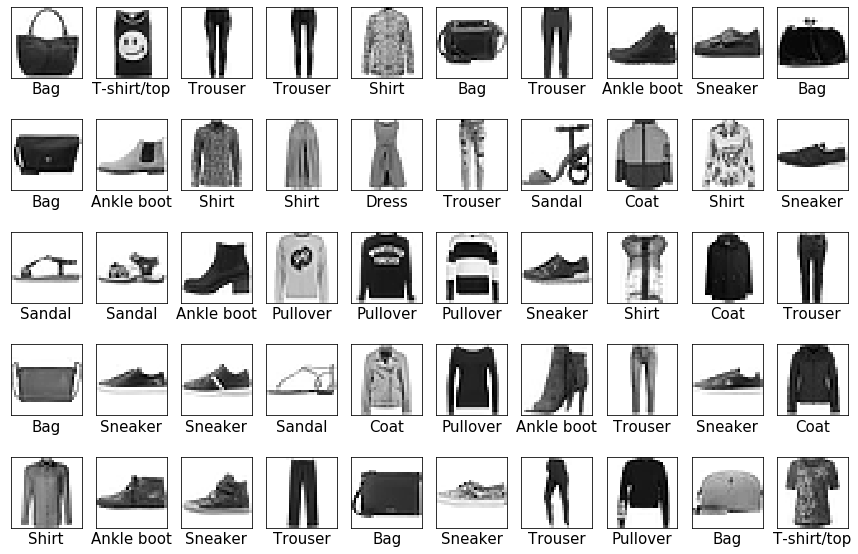

In [0]:
plt.figure(figsize=(15,10))
for i in range(100,150):
    plt.subplot(5,10,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(labels_list[y_train[i]])

## Задания

### Задание 1

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import style
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
%matplotlib inline 

Сначала создадим все функции для построения графиков

In [0]:
def conf_matrix(prediction):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, np.argmax(prediction, axis=1))
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=labels_list,
                          title='Confusion matrix')
    plt.show()

In [0]:
def precision_recall(prediction):
  n_classes = 10
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(y_test_categorical[:, i],
                                                          prediction[:, i])
      average_precision[i] = average_precision_score(y_test_categorical[:, i], prediction[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_categorical.ravel(),
      prediction.ravel())
  average_precision["micro"] = average_precision_score(y_test_categorical, prediction,
                                                      average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))
  

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'black', 'lime', 'pink', 'brown'])

  plt.figure(figsize=(10, 10))
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines = []
  labels = []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
      plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

  lines.append(l)
  labels.append('iso-f1 curves')
  l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
  lines.append(l)
  labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

  for i, color in zip(range(n_classes), colors):
      l, = plt.plot(recall[i], precision[i], color=color, lw=2)
      lines.append(l)
      labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Extension of Precision-Recall curve to multi-class')
  plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


  plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def print_statistic(y_test_categorical, prediction):
  average_precision = average_precision_score(y_test_categorical, prediction)
  accuracy = metrics.accuracy_score(y_test_categorical, prediction)
  roc_auc = roc_auc_score(y_test_categorical, prediction)
  print("Average precision-recall score: {0:0.4f}\nAccuracy: {1:0.4f}\nROC AUC: {2:0.4f}".format(average_precision, accuracy, roc_auc))
  print(metrics.classification_report(y_test, np.argmax(prediction, axis=1)))
  conf_matrix(prediction)
  roc_print(y_test_categorical, prediction)
  precision_recall(prediction)

In [0]:
def roc_print(y_test_categorical, prediction):
  n_classes=10
  fpr = dict()
  tpr = dict()
  lw=2
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], prediction[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_categorical.ravel(), prediction.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure(figsize=(10, 10))
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'black', 'lime', 'pink', 'brown'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(labels_list[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

Преобразуем в все данные в бинарный вид и нужную размерность

In [0]:
x_train = X_train.reshape(60000, 784)
x_train = x_train / 255 
x_test = X_test.reshape(10000, 784)
x_test = x_test / 255 
y_train = utils.to_categorical(y_train, 10)
y_test_categorical = utils.to_categorical(y_test, 10)

Используем в качестве модели RandomForest

Average precision-recall score: 0.7404
Accuracy: 0.7740
ROC AUC: 0.8834
              precision    recall  f1-score   support

           0       0.38      0.93      0.54      1000
           1       1.00      0.93      0.97      1000
           2       0.83      0.62      0.71      1000
           3       0.92      0.78      0.84      1000
           4       0.82      0.62      0.71      1000
           5       0.99      0.90      0.94      1000
           6       0.82      0.41      0.54      1000
           7       0.95      0.90      0.92      1000
           8       0.99      0.93      0.96      1000
           9       0.96      0.92      0.94      1000

    accuracy                           0.79     10000
   macro avg       0.86      0.79      0.81     10000
weighted avg       0.86      0.79      0.81     10000

Confusion matrix, without normalization
[[930   0   5  17   0   0  43   0   5   0]
 [ 51 934   0  12   1   0   2   0   0   0]
 [287   0 622   6  62   0  23   0   0   0]


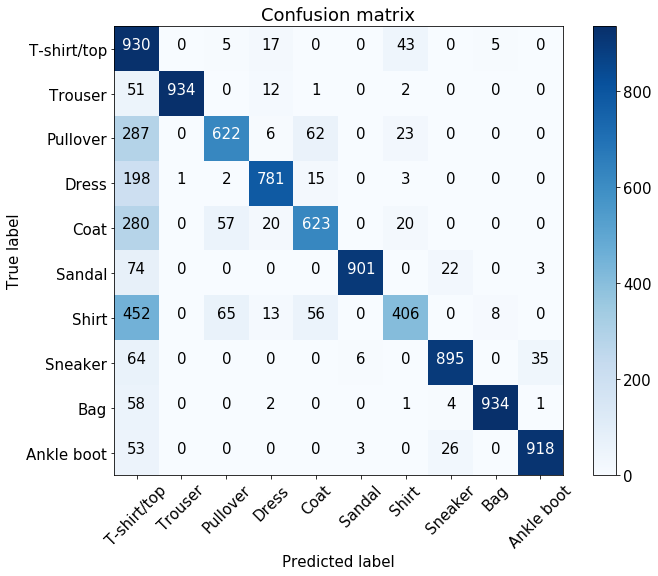

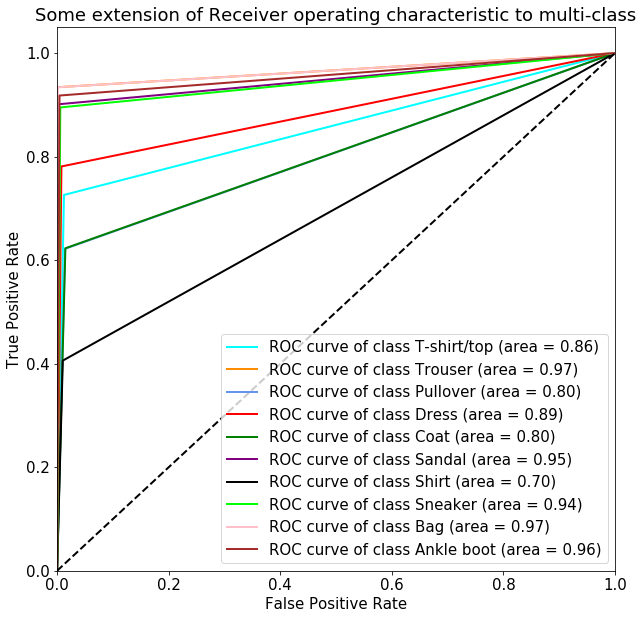

Average precision score, micro-averaged over all classes: 0.74


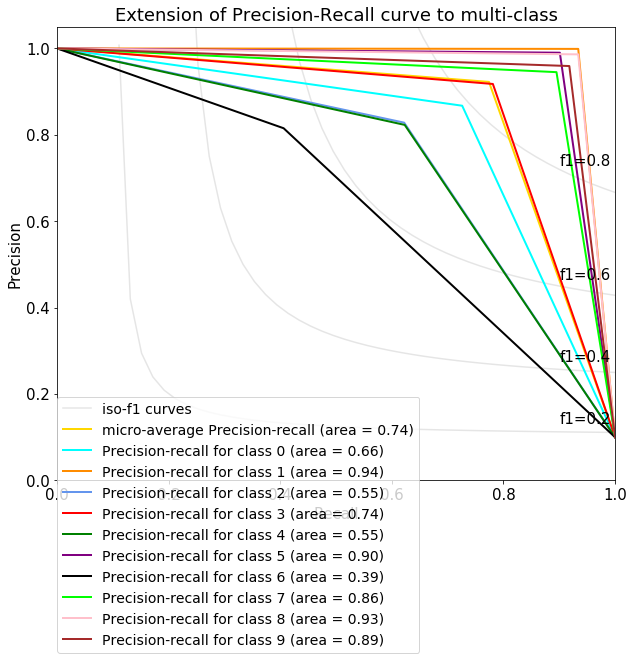

In [0]:
RFC = RandomForestClassifier().fit(x_train, y_train)
prediction_RFC = RFC.predict(x_test)
average_precision = average_precision_score(y_test_categorical, prediction_RFC)
accuracy = metrics.accuracy_score(y_test_categorical, prediction_RFC)
roc_auc = roc_auc_score(y_test_categorical, prediction_RFC)
print("Average precision-recall score: {0:0.4f}\nAccuracy: {1:0.4f}\nROC AUC: {2:0.4f}".format(average_precision, accuracy, roc_auc))
print(metrics.classification_report(y_test, np.argmax(prediction_RFC, axis=1)))
conf_matrix(prediction_RFC)
roc_print(y_test_categorical, prediction_RFC)
precision_recall(prediction_RFC)

Полученные результаты не слишком плохи, хотя могли бы быть и лучше. Accuracy равно 0.77. Roc равен 0.88 при этом самым ошибочным классом является Shirt, а также T-shirt/top. Но в целом на более отличительных классах (различающихся даже внешне), модель справляется неплохо

### Задание 2

In [0]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Построим самую простую модель с полносвязными слоями. В качестве входных данных (input_dim) используем 784 = 28*28, а выходные данные 10 классов с помощью активатора softmax.

In [0]:
model = Sequential()
model.add(Dense(800, input_dim=784, activation="relu"))
model.add(Dense(400, activation="relu"))
model.add(Dense(200, activation="relu"))
model.add(Dense(10, activation="softmax"))

Активатором используем "SGD", проверим 

In [0]:
model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 800)               628000    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________
None


Обучаем модель и предсказываем на тестовой выборке результаты, после посмотрим итоги

In [0]:
model.fit(x_train, y_train, 
          batch_size=200, 
          epochs=25,  
          verbose=1)

Train on 60000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 60us/sample - loss: 1.1282 - acc: 0.6669
Epoch 2/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.7246 - acc: 0.7752
Epoch 3/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.6343 - acc: 0.7995
Epoch 4/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.5854 - acc: 0.8124
Epoch 5/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.5534 - acc: 0.8196
Epoch 6/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.5298 - acc: 0.8264
Epoch 7/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.5130 - acc: 0.8303
Epoch 8/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.4990 - acc: 0.8338
Epoch 9/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.4873 - acc: 0.8374
Epoch 10/100
60000/60000 [========================

In [0]:
prediction_ns = model.predict(x_test)

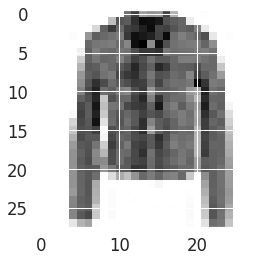

[3.4800294e-04 1.2367581e-03 1.4046404e-01 3.3786602e-04 8.1692153e-01
 8.4871118e-08 4.0052470e-02 6.0191874e-10 6.3925027e-04 1.4518650e-09]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Coat
Coat


In [0]:
n = 10
plt.imshow(x_test[n].reshape(28, 28), cmap=plt.cm.binary)
plt.show()
print(prediction_ns[n])
print(y_test_categorical[n])
print(labels_list[np.argmax(prediction_ns[n])])
print(labels_list[np.argmax(y_test_categorical[n])])

In [0]:
n=1111
print(np.argmax(prediction_ns, axis=1)[n])
print(np.argmax(y_test_categorical, axis=1)[n])

3
0


In [0]:
np.argmax(prediction_ns, axis=1)

array([9, 2, 1, ..., 8, 1, 5])

In [0]:
np.argmax(y_test_categorical, axis=1)

array([9, 2, 1, ..., 8, 1, 5])

Average precision-recall score: 0.9268
Accuracy: 0.8710
ROC AUC: 0.9887
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1000
           1       0.98      0.96      0.97      1000
           2       0.77      0.81      0.79      1000
           3       0.83      0.90      0.86      1000
           4       0.80      0.77      0.79      1000
           5       0.96      0.95      0.95      1000
           6       0.72      0.63      0.67      1000
           7       0.91      0.95      0.93      1000
           8       0.95      0.96      0.95      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion matrix, without normalization
[[836   0  14  46   5   1  86   0  12   0]
 [  3 962   2  26   3   0   3   0   1   0]
 [ 16   2 808  19  89   1  59   0   6   0]


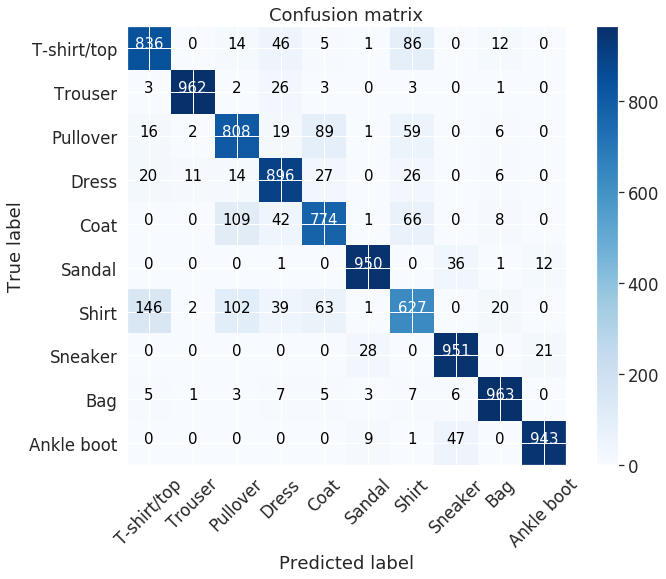

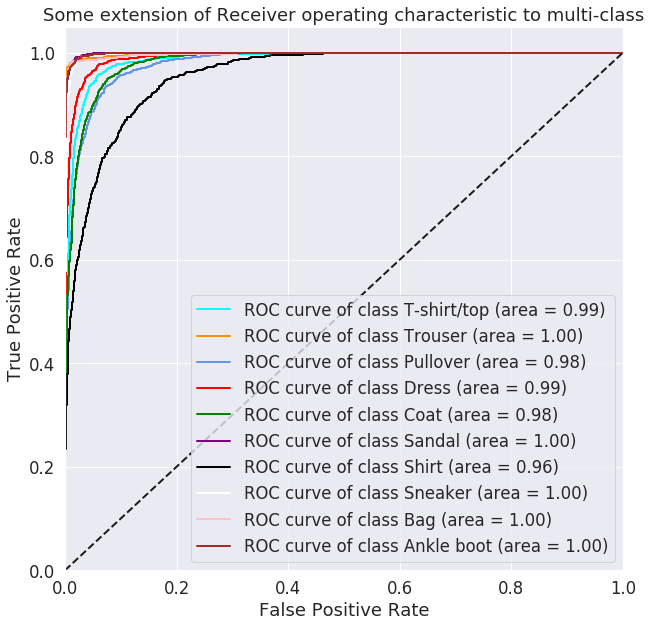

Average precision score, micro-averaged over all classes: 0.95


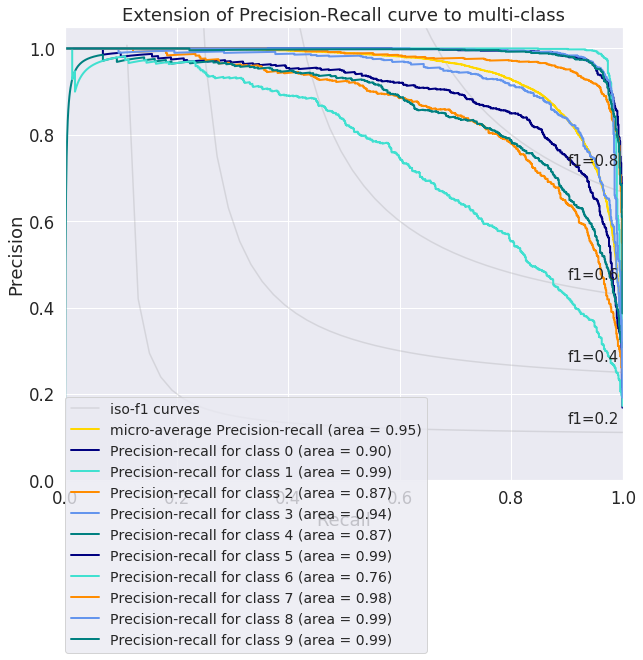

In [0]:
average_precision = average_precision_score(y_test_categorical, prediction_ns)
accuracy = metrics.accuracy_score(y_test, np.argmax(prediction_ns, axis=1))
roc_auc = roc_auc_score(y_test_categorical, prediction_ns)
print("Average precision-recall score: {0:0.4f}\nAccuracy: {1:0.4f}\nROC AUC: {2:0.4f}".format(average_precision, accuracy, roc_auc))
print(metrics.classification_report(y_test, np.argmax(prediction_ns, axis=1)))
conf_matrix(prediction_ns)
roc_print(y_test_categorical, prediction_ns)
precision_recall(prediction_ns)

Результаты намного лучше, чем у RandomForest. Accuracy = 0.87. Самыми ошибочными классоми все еще являются теже самые. 

Теперь попробуем подобрать наиболее лучшие характеристики, тестировать будем на epochs = 25, для экономии времени. Для начала попробуем изменить batch_size на более высокий и более низкий

In [0]:
model1 = Sequential()
model1.add(Dense(800, input_dim=784, activation="relu"))
model1.add(Dense(400, activation="relu"))
model1.add(Dense(200, activation="relu"))
model1.add(Dense(10, activation="softmax"))
model1.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
model1.fit(x_train, y_train, 
          batch_size=800, 
          epochs=25,  
          verbose=2)

Train on 60000 samples
Epoch 1/25
60000/60000 - 3s - loss: 1.6524 - acc: 0.5384
Epoch 2/25
60000/60000 - 2s - loss: 1.0904 - acc: 0.6902
Epoch 3/25
60000/60000 - 2s - loss: 0.9142 - acc: 0.7236
Epoch 4/25
60000/60000 - 2s - loss: 0.8248 - acc: 0.7456
Epoch 5/25
60000/60000 - 2s - loss: 0.7681 - acc: 0.7602
Epoch 6/25
60000/60000 - 2s - loss: 0.7277 - acc: 0.7719
Epoch 7/25
60000/60000 - 2s - loss: 0.6967 - acc: 0.7823
Epoch 8/25
60000/60000 - 2s - loss: 0.6721 - acc: 0.7878
Epoch 9/25
60000/60000 - 2s - loss: 0.6515 - acc: 0.7948
Epoch 10/25
60000/60000 - 2s - loss: 0.6343 - acc: 0.8000
Epoch 11/25
60000/60000 - 2s - loss: 0.6192 - acc: 0.8041
Epoch 12/25
60000/60000 - 2s - loss: 0.6063 - acc: 0.8073
Epoch 13/25
60000/60000 - 2s - loss: 0.5946 - acc: 0.8102
Epoch 14/25
60000/60000 - 2s - loss: 0.5843 - acc: 0.8127
Epoch 15/25
60000/60000 - 2s - loss: 0.5750 - acc: 0.8151
Epoch 16/25
60000/60000 - 2s - loss: 0.5666 - acc: 0.8183
Epoch 17/25
60000/60000 - 2s - loss: 0.5591 - acc: 0.8201


In [0]:
model2 = Sequential()
model2.add(Dense(800, input_dim=784, activation="relu"))
model2.add(Dense(400, activation="relu"))
model2.add(Dense(200, activation="relu"))
model2.add(Dense(10, activation="softmax"))
model2.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
model2.fit(x_train, y_train, 
          batch_size=100, 
          epochs=25,  
          verbose=2)

Train on 60000 samples
Epoch 1/25
60000/60000 - 5s - loss: 0.9379 - acc: 0.7190
Epoch 2/25
60000/60000 - 5s - loss: 0.6170 - acc: 0.8028
Epoch 3/25
60000/60000 - 5s - loss: 0.5470 - acc: 0.8209
Epoch 4/25
60000/60000 - 5s - loss: 0.5101 - acc: 0.8297
Epoch 5/25
60000/60000 - 5s - loss: 0.4857 - acc: 0.8374
Epoch 6/25
60000/60000 - 5s - loss: 0.4685 - acc: 0.8413
Epoch 7/25
60000/60000 - 5s - loss: 0.4553 - acc: 0.8451
Epoch 8/25
60000/60000 - 5s - loss: 0.4445 - acc: 0.8488
Epoch 9/25
60000/60000 - 5s - loss: 0.4347 - acc: 0.8522
Epoch 10/25
60000/60000 - 5s - loss: 0.4262 - acc: 0.8543
Epoch 11/25
60000/60000 - 5s - loss: 0.4193 - acc: 0.8558
Epoch 12/25
60000/60000 - 5s - loss: 0.4132 - acc: 0.8589
Epoch 13/25
60000/60000 - 5s - loss: 0.4071 - acc: 0.8614
Epoch 14/25
60000/60000 - 5s - loss: 0.4020 - acc: 0.8614
Epoch 15/25
60000/60000 - 5s - loss: 0.3972 - acc: 0.8629
Epoch 16/25
60000/60000 - 5s - loss: 0.3924 - acc: 0.8648
Epoch 17/25
60000/60000 - 5s - loss: 0.3884 - acc: 0.8669


Итогом является то, что batch_size лучше использовать равным 100, так как с ним acc примерно на 0.015 больше. Теперь изменим количество нейронов на 1 уровне в меньшую сторону, например до 256

In [0]:
model3 = Sequential()
model3.add(Dense(256, input_dim=784, activation="relu"))
model3.add(Dense(256, activation="relu"))
model3.add(Dense(128, activation="relu"))
model3.add(Dense(10, activation="softmax"))
model3.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
model3.fit(x_train, y_train, 
          batch_size=100, 
          epochs=25,  
          verbose=2)

Train on 60000 samples
Epoch 1/25
60000/60000 - 3s - loss: 0.9617 - acc: 0.7044
Epoch 2/25
60000/60000 - 3s - loss: 0.6292 - acc: 0.7970
Epoch 3/25
60000/60000 - 3s - loss: 0.5579 - acc: 0.8164
Epoch 4/25
60000/60000 - 3s - loss: 0.5196 - acc: 0.8255
Epoch 5/25
60000/60000 - 2s - loss: 0.4952 - acc: 0.8328
Epoch 6/25
60000/60000 - 3s - loss: 0.4778 - acc: 0.8384
Epoch 7/25
60000/60000 - 3s - loss: 0.4637 - acc: 0.8421
Epoch 8/25
60000/60000 - 3s - loss: 0.4522 - acc: 0.8460
Epoch 9/25
60000/60000 - 3s - loss: 0.4427 - acc: 0.8486
Epoch 10/25
60000/60000 - 3s - loss: 0.4349 - acc: 0.8504
Epoch 11/25
60000/60000 - 3s - loss: 0.4276 - acc: 0.8526
Epoch 12/25
60000/60000 - 3s - loss: 0.4213 - acc: 0.8550
Epoch 13/25
60000/60000 - 3s - loss: 0.4156 - acc: 0.8564
Epoch 14/25
60000/60000 - 3s - loss: 0.4105 - acc: 0.8581
Epoch 15/25
60000/60000 - 3s - loss: 0.4057 - acc: 0.8599
Epoch 16/25
60000/60000 - 3s - loss: 0.4011 - acc: 0.8622
Epoch 17/25
60000/60000 - 3s - loss: 0.3969 - acc: 0.8643


Показатель accuracy чуть-чуть уменьшился, примерно на 0.003. Но эти изменения не значительные, в свою очередь по времени нейросеть работает почти в 2 раза быстрее. Теперь на очередь показатель оптимизатора. Попробуем такие как adagrad и adam.

In [0]:
model4 = Sequential()
model4.add(Dense(256, input_dim=784, activation="relu"))
model4.add(Dense(256, activation="relu"))
model4.add(Dense(128, activation="relu"))
model4.add(Dense(10, activation="softmax"))
model4.compile(loss="categorical_crossentropy", optimizer="adagrad", metrics=["accuracy"])
model4.fit(x_train, y_train, 
          batch_size=100, 
          epochs=25,  
          verbose=2)

Train on 60000 samples
Epoch 1/25
60000/60000 - 3s - loss: 0.7098 - acc: 0.7757
Epoch 2/25
60000/60000 - 3s - loss: 0.5526 - acc: 0.8220
Epoch 3/25
60000/60000 - 3s - loss: 0.5147 - acc: 0.8324
Epoch 4/25
60000/60000 - 3s - loss: 0.4928 - acc: 0.8380
Epoch 5/25
60000/60000 - 3s - loss: 0.4781 - acc: 0.8418
Epoch 6/25
60000/60000 - 3s - loss: 0.4674 - acc: 0.8444
Epoch 7/25
60000/60000 - 3s - loss: 0.4589 - acc: 0.8473
Epoch 8/25
60000/60000 - 3s - loss: 0.4519 - acc: 0.8489
Epoch 9/25
60000/60000 - 3s - loss: 0.4455 - acc: 0.8510
Epoch 10/25
60000/60000 - 3s - loss: 0.4404 - acc: 0.8521
Epoch 11/25
60000/60000 - 3s - loss: 0.4360 - acc: 0.8538
Epoch 12/25
60000/60000 - 3s - loss: 0.4317 - acc: 0.8554
Epoch 13/25
60000/60000 - 3s - loss: 0.4279 - acc: 0.8563
Epoch 14/25
60000/60000 - 3s - loss: 0.4246 - acc: 0.8568
Epoch 15/25
60000/60000 - 3s - loss: 0.4214 - acc: 0.8575
Epoch 16/25
60000/60000 - 3s - loss: 0.4186 - acc: 0.8586
Epoch 17/25
60000/60000 - 3s - loss: 0.4158 - acc: 0.8595


In [0]:
model5 = Sequential()
model5.add(Dense(256, input_dim=784, activation="relu"))
model5.add(Dense(256, activation="relu"))
model5.add(Dense(128,activation="relu"))
model5.add(Dense(10, activation="softmax"))
model5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model5.fit(x_train, y_train, 
          batch_size=100, 
          epochs=25,  
          verbose=2)

Train on 60000 samples
Epoch 1/25
60000/60000 - 3s - loss: 0.5100 - acc: 0.8231
Epoch 2/25
60000/60000 - 3s - loss: 0.3792 - acc: 0.8646
Epoch 3/25
60000/60000 - 3s - loss: 0.3408 - acc: 0.8761
Epoch 4/25
60000/60000 - 3s - loss: 0.3165 - acc: 0.8833
Epoch 5/25
60000/60000 - 3s - loss: 0.2964 - acc: 0.8916
Epoch 6/25
60000/60000 - 3s - loss: 0.2799 - acc: 0.8983
Epoch 7/25
60000/60000 - 3s - loss: 0.2697 - acc: 0.9013
Epoch 8/25
60000/60000 - 3s - loss: 0.2556 - acc: 0.9058
Epoch 9/25
60000/60000 - 3s - loss: 0.2460 - acc: 0.9083
Epoch 10/25
60000/60000 - 3s - loss: 0.2366 - acc: 0.9129
Epoch 11/25
60000/60000 - 3s - loss: 0.2274 - acc: 0.9161
Epoch 12/25
60000/60000 - 3s - loss: 0.2222 - acc: 0.9169
Epoch 13/25
60000/60000 - 3s - loss: 0.2119 - acc: 0.9211
Epoch 14/25
60000/60000 - 3s - loss: 0.2053 - acc: 0.9237
Epoch 15/25
60000/60000 - 3s - loss: 0.1999 - acc: 0.9260
Epoch 16/25
60000/60000 - 3s - loss: 0.1921 - acc: 0.9290
Epoch 17/25
60000/60000 - 3s - loss: 0.1837 - acc: 0.9314


Оказалось, что наилучшим образом проявляет себя оптимизатор adam, который намного поднял показатель occuracy. Теперь сделаем 3 слой нейросети и посмотрим, что из этого выйдет.

In [0]:
model6 = Sequential()
model6.add(Dense(256, input_dim=784, activation="relu"))
model6.add(Dense(256, activation="relu"))
model6.add(Dense(128, activation="relu"))
model6.add(Dense(64, activation="relu"))
model6.add(Dense(10, activation="softmax"))
model6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model6.fit(x_train, y_train, 
          batch_size=100, 
          epochs=25,  
          verbose=2)

Train on 60000 samples
Epoch 1/25
60000/60000 - 4s - loss: 0.5015 - acc: 0.8225
Epoch 2/25
60000/60000 - 4s - loss: 0.3644 - acc: 0.8672
Epoch 3/25
60000/60000 - 3s - loss: 0.3222 - acc: 0.8817
Epoch 4/25
60000/60000 - 4s - loss: 0.2989 - acc: 0.8898
Epoch 5/25
60000/60000 - 3s - loss: 0.2833 - acc: 0.8946
Epoch 6/25
60000/60000 - 3s - loss: 0.2691 - acc: 0.8997
Epoch 7/25
60000/60000 - 3s - loss: 0.2567 - acc: 0.9037
Epoch 8/25
60000/60000 - 3s - loss: 0.2432 - acc: 0.9093
Epoch 9/25
60000/60000 - 3s - loss: 0.2347 - acc: 0.9131
Epoch 10/25
60000/60000 - 4s - loss: 0.2245 - acc: 0.9161
Epoch 11/25
60000/60000 - 4s - loss: 0.2174 - acc: 0.9183
Epoch 12/25
60000/60000 - 4s - loss: 0.2075 - acc: 0.9216
Epoch 13/25
60000/60000 - 4s - loss: 0.2017 - acc: 0.9236
Epoch 14/25
60000/60000 - 3s - loss: 0.1933 - acc: 0.9254
Epoch 15/25
60000/60000 - 3s - loss: 0.1881 - acc: 0.9283
Epoch 16/25
60000/60000 - 3s - loss: 0.1813 - acc: 0.9309
Epoch 17/25
60000/60000 - 3s - loss: 0.1730 - acc: 0.9351


3 слой немного увеличил время работы, но при этом поднял показатели еще выше. Теперь используем все полученные знания, чтоб по максимуму использовать все параметры нейросети.

In [0]:
model_res = Sequential()
model_res.add(Dense(256, input_dim=784, activation="relu"))
model_res.add(Dense(256, activation="relu"))
model_res.add(Dense(128, activation="relu"))
model_res.add(Dense(64, activation="relu"))
model_res.add(Dense(10, activation="softmax"))
model_res.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_res.fit(x_train, y_train, 
          batch_size=100, 
          epochs=100,  
          verbose=2)

Train on 60000 samples
Epoch 1/100
60000/60000 - 3s - loss: 0.5004 - acc: 0.8230
Epoch 2/100
60000/60000 - 3s - loss: 0.3653 - acc: 0.8660
Epoch 3/100
60000/60000 - 3s - loss: 0.3287 - acc: 0.8796
Epoch 4/100
60000/60000 - 3s - loss: 0.3008 - acc: 0.8893
Epoch 5/100
60000/60000 - 3s - loss: 0.2838 - acc: 0.8939
Epoch 6/100
60000/60000 - 3s - loss: 0.2682 - acc: 0.9004
Epoch 7/100
60000/60000 - 3s - loss: 0.2557 - acc: 0.9049
Epoch 8/100
60000/60000 - 3s - loss: 0.2467 - acc: 0.9079
Epoch 9/100
60000/60000 - 3s - loss: 0.2320 - acc: 0.9124
Epoch 10/100
60000/60000 - 3s - loss: 0.2267 - acc: 0.9149
Epoch 11/100
60000/60000 - 3s - loss: 0.2182 - acc: 0.9176
Epoch 12/100
60000/60000 - 3s - loss: 0.2120 - acc: 0.9205
Epoch 13/100
60000/60000 - 3s - loss: 0.2006 - acc: 0.9230
Epoch 14/100
60000/60000 - 3s - loss: 0.1935 - acc: 0.9268
Epoch 15/100
60000/60000 - 3s - loss: 0.1850 - acc: 0.9305
Epoch 16/100
60000/60000 - 3s - loss: 0.1811 - acc: 0.9315
Epoch 17/100
60000/60000 - 3s - loss: 0.17

accuracy равно почти 0.99, переходим к предикту на основе этой моделе

In [0]:
prediction_ns = model_res.predict(x_test)

Average precision-recall score: 0.9342
Accuracy: 0.8936
ROC AUC: 0.9896
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.92      0.87      0.89      1000
           4       0.83      0.82      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.74      0.70      0.72      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion matrix, without normalization
[[877   1  14  11   4   1  86   0   6   0]
 [  4 983   0   7   3   0   2   0   1   0]
 [ 17   2 829   7  72   1  71   0   1   0]


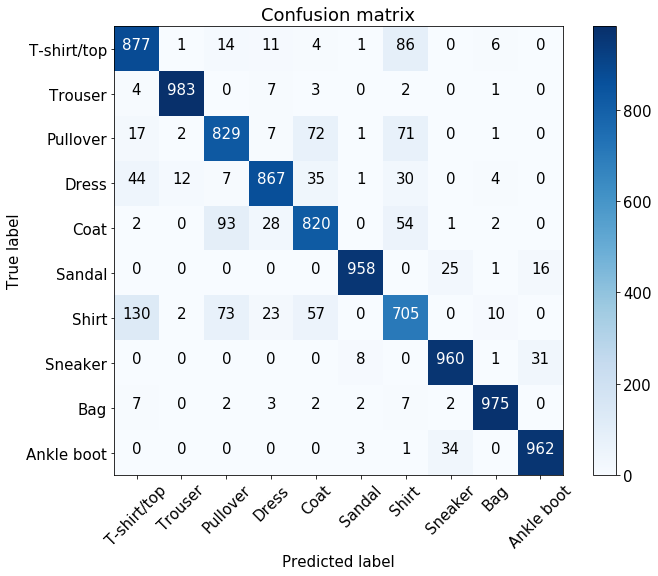

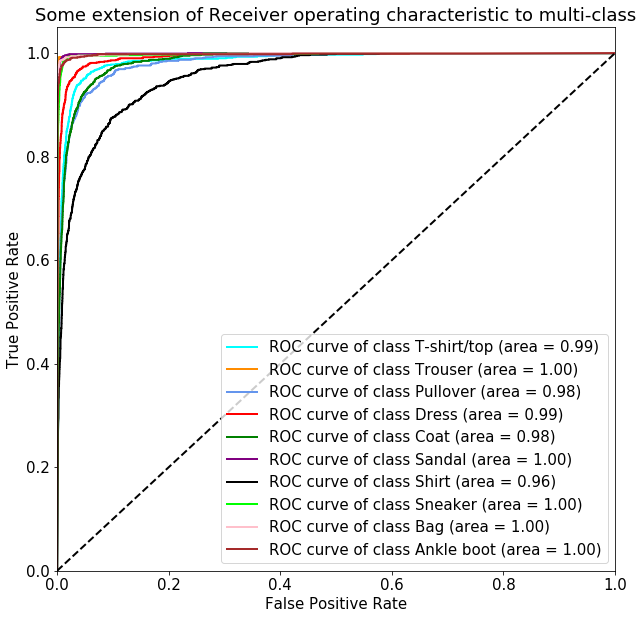

Average precision score, micro-averaged over all classes: 0.95


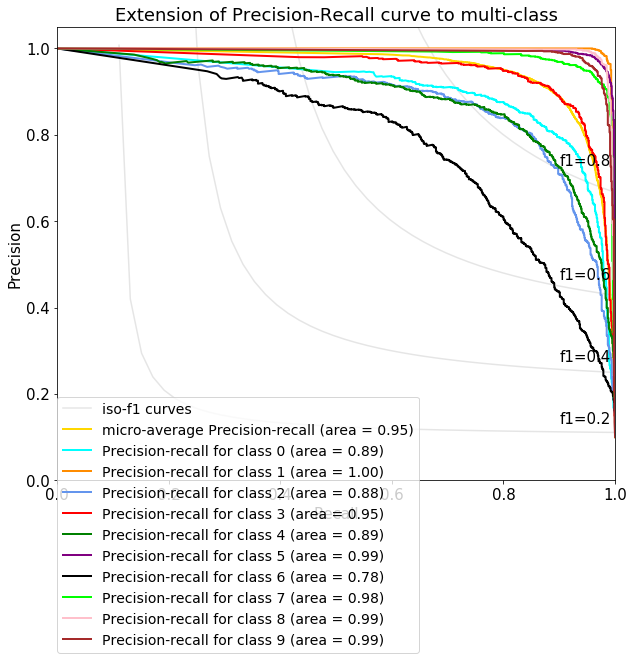

In [0]:
average_precision = average_precision_score(y_test_categorical, prediction_ns)
accuracy = metrics.accuracy_score(y_test, np.argmax(prediction_ns, axis=1))
roc_auc = roc_auc_score(y_test_categorical, prediction_ns)
print("Average precision-recall score: {0:0.4f}\nAccuracy: {1:0.4f}\nROC AUC: {2:0.4f}".format(average_precision, accuracy, roc_auc))
print(metrics.classification_report(y_test, np.argmax(prediction_ns, axis=1)))
conf_matrix(prediction_ns)
roc_print(y_test_categorical, prediction_ns)
precision_recall(prediction_ns)

Итог мы получили еще лучшие результаты модели. Итогом является можель model_res с accuracy 0.89

### Задание 3

Анализировать будем по confusion_matrix, суммируя все что лежит не на главной диагонале

In [0]:
cnf_matrix = confusion_matrix(y_test, np.argmax(prediction_ns, axis=1))
print(cnf_matrix)

[[877   1  14  11   4   1  86   0   6   0]
 [  4 983   0   7   3   0   2   0   1   0]
 [ 17   2 829   7  72   1  71   0   1   0]
 [ 44  12   7 867  35   1  30   0   4   0]
 [  2   0  93  28 820   0  54   1   2   0]
 [  0   0   0   0   0 958   0  25   1  16]
 [130   2  73  23  57   0 705   0  10   0]
 [  0   0   0   0   0   8   0 960   1  31]
 [  7   0   2   3   2   2   7   2 975   0]
 [  0   0   0   0   0   3   1  34   0 962]]


In [0]:
freq = []
for i in range(10):
  for j in range(10):
    if i > j:
      freq.append((i, j, cnf_matrix[i][j]+cnf_matrix[j][i]))

In [0]:
print(freq)

[(1, 0, 5), (2, 0, 31), (2, 1, 2), (3, 0, 55), (3, 1, 19), (3, 2, 14), (4, 0, 6), (4, 1, 3), (4, 2, 165), (4, 3, 63), (5, 0, 1), (5, 1, 0), (5, 2, 1), (5, 3, 1), (5, 4, 0), (6, 0, 216), (6, 1, 4), (6, 2, 144), (6, 3, 53), (6, 4, 111), (6, 5, 0), (7, 0, 0), (7, 1, 0), (7, 2, 0), (7, 3, 0), (7, 4, 1), (7, 5, 33), (7, 6, 0), (8, 0, 13), (8, 1, 1), (8, 2, 3), (8, 3, 7), (8, 4, 4), (8, 5, 3), (8, 6, 17), (8, 7, 3), (9, 0, 0), (9, 1, 0), (9, 2, 0), (9, 3, 0), (9, 4, 0), (9, 5, 19), (9, 6, 1), (9, 7, 65), (9, 8, 0)]


In [0]:
max_freq = sorted(min_res, key=lambda x: x[2], reverse=True)[:5]
print(max_freq)

[(6, 0, 229), (4, 2, 172), (6, 4, 139), (6, 2, 136), (4, 3, 66)]


Создали список из самых путающихся гласов и частота ошибок в них. Переведем для понимания в слова.

In [0]:
max_freq_l = []
for i in range(5):
  max_freq_l.append((labels_list[max_freq[i][0]], labels_list[max_freq[i][1]], max_freq[i][2]))
print(max_freq_l)

[('Shirt', 'T-shirt/top', 229), ('Coat', 'Pullover', 172), ('Shirt', 'Coat', 139), ('Shirt', 'Pullover', 136), ('Coat', 'Dress', 66)]


С логичной точки зрения это обяъсняется очень просто. Все эти вещи одинаковы по фасону. Путается shirt и t-shirt, так как это в принципе почти одно и тоже, и выглядит одиннаково. Плащ и платье, как в принципе и свитер длинные. Свитер может быть спутан с футболкой. Сложно спутать с чем то сумку или сандали.

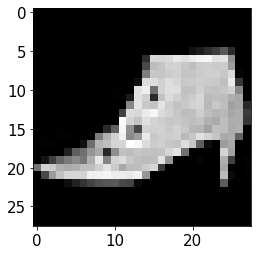

Prediction:  Ankle boot
Real:  Ankle boot


In [0]:
pic_id = 132
some_pic = x_test[pic_id]
pic_label = y_test[pic_id]
pred_label = np.argmax(prediction_ns[pic_id])
plt.imshow(some_pic.reshape((28, 28)), cmap='gray')
plt.show()
print("Prediction: ", labels_list[pred_label])
print("Real: ", labels_list[pic_label])

In [0]:
def confusion_between(i1, i2): 
  print("Examples of confusion between", labels_list[i1], "and", labels_list[i2])
  k = 0
  for i in range(10000):
    pic_id = i
    pic_label = y_test[pic_id]
    pred_label = np.argmax(prediction_ns[pic_id])
    if (pred_label == i1 and pic_label == i2) or (pic_label == i2 and pred_label == i1):
      some_pic = x_test[pic_id]
      plt.subplot(1, 5, k+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(some_pic.reshape((28, 28)), cmap='gray')
      k += 1
      if k == 5:
        break
  plt.show()

Выведем примеры таких путаниц, используя написанную функцию

Examples of confusion between Shirt and T-shirt/top


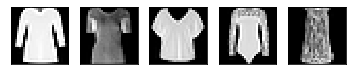

Examples of confusion between Coat and Pullover


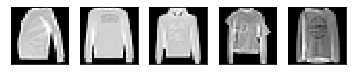

Examples of confusion between Shirt and Coat


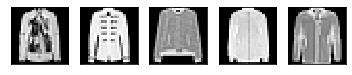

Examples of confusion between Shirt and Pullover


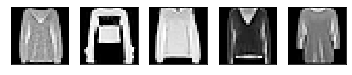

Examples of confusion between Coat and Dress


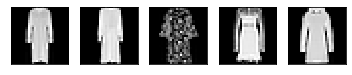

In [0]:
for i in range(len(max_freq)):
  confusion_between(max_freq[i][0], max_freq[i][1])

Судя по classification_report почти все классы определяются с одинаковой вероятностью примерно в 80%. Однако есть пару исключений как в большую, так и меньшую сторону. Судя по следующим данным очень сильно вниз отличается футболка, так как она коррелирует с многими другими классами, так как в целом имеет много общего с ними исходя из внешнего вида.

In [0]:
f1 = metrics.f1_score(y_test, np.argmax(prediction_ns, axis=1), average=None)
print("Max =", f1.max(), "at", labels_list[f1.argmax()])
print("Min =", f1.min(), "at", labels_list[f1.argmin()])

Max = 0.983 at Trouser
Min = 0.7208588957055214 at Shirt


### Задание 4

Изменим измерения массивов к 4 dimentions

In [0]:
train_img_x, train_img_y = load_mnist('data', kind='train')
test_img_x, test_img_y = load_mnist('data', kind='t10k')

In [0]:
train_img_x = train_img_x.reshape(60000,28,28,1)
test_img_x = test_img_x.reshape(10000,28,28,1)

In [0]:
train_img_y = utils.to_categorical(train_img_y, 10)
test_img_y = utils.to_categorical(test_img_y, 10)

In [0]:
train_img_x[0][13][13][0]

236

Попробуем использовать Conv2D и Flatten

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
ns1 = Sequential()
#add model layers
ns1.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
ns1.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1)))
ns1.add(Flatten())
ns1.add(Dense(10, activation='softmax'))

In [0]:
ns1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
ns1.fit(train_img_x, train_img_y, batch_size=100, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 154s 3ms/step - loss: 12.9354 - acc: 0.1973
Epoch 2/3
60000/60000 [==============================] - 153s 3ms/step - loss: 12.9470 - acc: 0.1967
Epoch 3/3
60000/60000 [==============================] - 153s 3ms/step - loss: 12.9722 - acc: 0.1952


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

num_filters = 1
filter_size = 1
pool_size = 2

ns2 = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(10, activation='softmax'),
])
ns2.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
ns2.fit(train_img_x, train_img_y, batch_size=100, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 6s 96us/step - loss: 4.0635 - acc: 0.5803
Epoch 2/3
60000/60000 [==============================] - 5s 81us/step - loss: 0.6725 - acc: 0.7646
Epoch 3/3
60000/60000 [==============================] - 5s 80us/step - loss: 0.6050 - acc: 0.7899


In [0]:
ns3 =  Sequential()
ns3.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(28, 28, 1)))
ns3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
ns3.add(Conv2D(64, (5, 5), activation='relu'))
ns3.add(MaxPooling2D(pool_size=(2, 2)))
ns3.add(Flatten())
ns3.add(Dense(100, activation='relu'))
ns3.add(Dense(10, activation='softmax'))
ns3.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
ns3.fit(train_img_x, train_img_y, batch_size=100, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 56s 928us/step - loss: 1.1831 - acc: 0.7923
Epoch 2/3
60000/60000 [==============================] - 55s 909us/step - loss: 0.3326 - acc: 0.8797
Epoch 3/3
60000/60000 [==============================] - 54s 908us/step - loss: 0.2877 - acc: 0.8950


Обучим последнюю модель, которая показала лучшие результаты еще на 15 epoch и проверим результат на тестовой выборкеу

In [0]:
ns3.fit(train_img_x, train_img_y, batch_size=100, epochs=15)

Epoch 1/15
60000/60000 [==============================] - 55s 919us/step - loss: 0.2516 - acc: 0.9072
Epoch 2/15
60000/60000 [==============================] - 54s 903us/step - loss: 0.2317 - acc: 0.9134
Epoch 3/15
60000/60000 [==============================] - 54s 905us/step - loss: 0.2162 - acc: 0.9202
Epoch 4/15
60000/60000 [==============================] - 54s 903us/step - loss: 0.2041 - acc: 0.9236
Epoch 5/15
60000/60000 [==============================] - 54s 904us/step - loss: 0.1888 - acc: 0.9302
Epoch 6/15
60000/60000 [==============================] - 54s 903us/step - loss: 0.1778 - acc: 0.9333
Epoch 7/15
60000/60000 [==============================] - 54s 902us/step - loss: 0.1673 - acc: 0.9367
Epoch 8/15
60000/60000 [==============================] - 54s 902us/step - loss: 0.1607 - acc: 0.9391
Epoch 9/15
60000/60000 [==============================] - 54s 905us/step - loss: 0.1419 - acc: 0.9459
Epoch 10/15
60000/60000 [==============================] - 54s 904us/step - loss: 

In [0]:
prediction_ns = ns3.predict(test_img_x)

Average precision-recall score: 0.9427
Accuracy: 0.8936
ROC AUC: 0.9912
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.92      0.87      0.89      1000
           4       0.83      0.82      0.83      1000
           5       0.98      0.98      0.98      1000
           6       0.69      0.72      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion matrix, without normalization
[[825   3  29  11   5   2 123   0   2   0]
 [  2 980   0   9   2   0   5   0   2   0]
 [ 14   1 841   9  61   0  72   0   2   0]


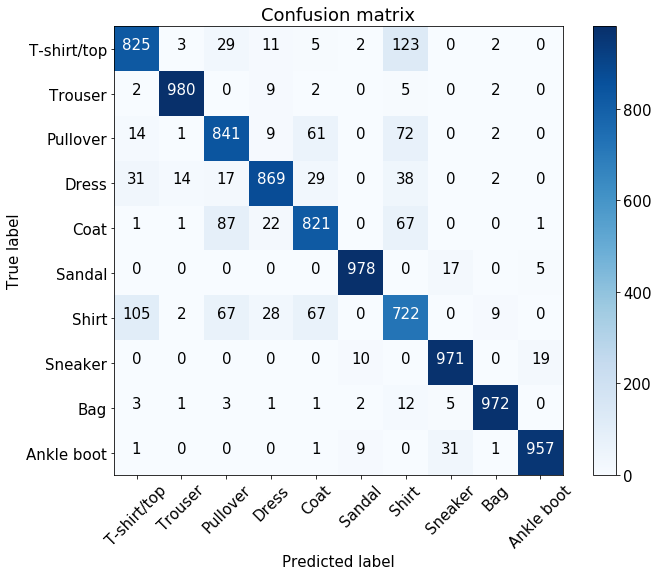

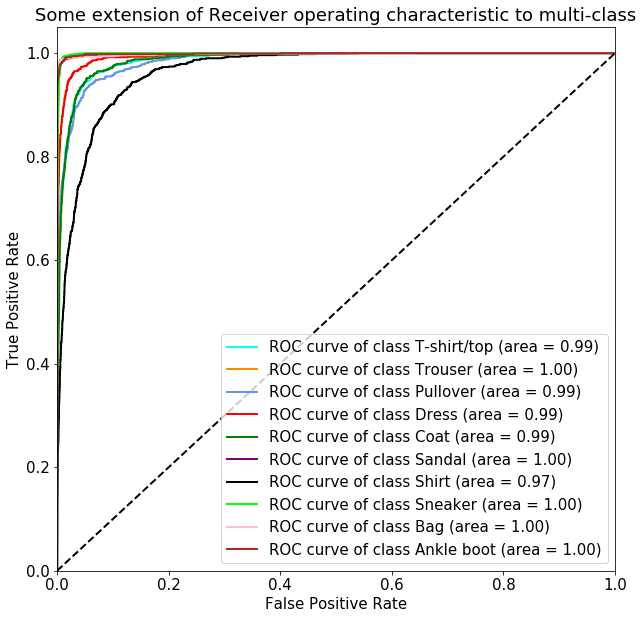

Average precision score, micro-averaged over all classes: 0.96


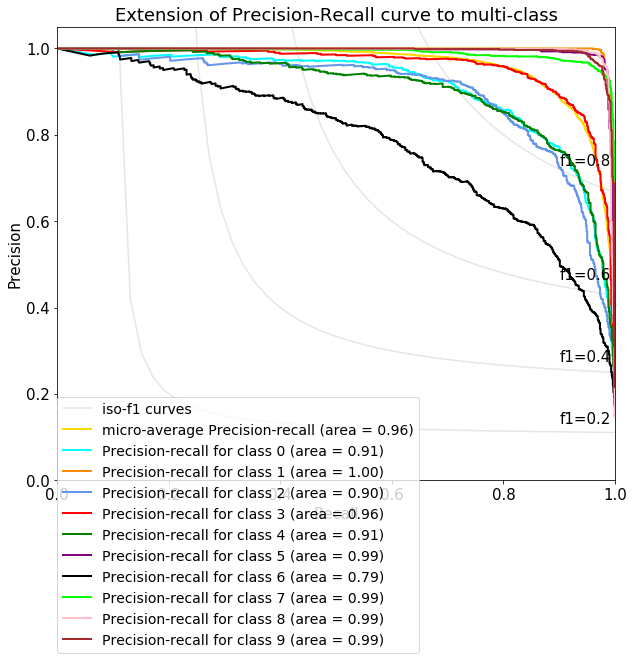

In [0]:
average_precision = average_precision_score(y_test_categorical, prediction_ns)
accuracy = metrics.accuracy_score(y_test, np.argmax(prediction_ns, axis=1))
roc_auc = roc_auc_score(y_test_categorical, prediction_ns)
print("Average precision-recall score: {0:0.4f}\nAccuracy: {1:0.4f}\nROC AUC: {2:0.4f}".format(average_precision, accuracy, roc_auc))
print(metrics.classification_report(y_test, np.argmax(prediction_ns, axis=1)))
conf_matrix(prediction_ns)
roc_print(y_test_categorical, prediction_ns)
precision_recall(prediction_ns)

Итогом является в целом хорошо работающие (90%) модели нейросети и RandomForest, которые позволяют предсказывать тип одежды по фотографии